# Fraudulent Transactions Prediction
The dataset used in this notebook can obted in link ¹

¹ https://www.kaggle.com/code/chaurasiya123/fraudlent-transaction-prediction/data

## Imports

In [1]:
from pandas.core.common import random_state
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import KMeansSMOTE, RandomOverSampler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot



import warnings

warnings.filterwarnings('ignore')

Random_state = 21

## Dataset

About Dataset:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
#Read dataset
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Checking types of each column
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [4]:
#Checking missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
#Checking duplicates values
df.duplicated().sum()

0

In [6]:
#Descriptive statics
df.describe(include = 'all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6362620.0,NaN,NaN,NaN,243.397246,142.331971,1.0,156.0,239.0,335.0,743.0
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6362620.0,NaN,NaN,NaN,179861.903549,603858.231463,0.0,13389.57,74871.94,208721.4775,92445516.64
nameOrig,6362620,6353307,C1902386530,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,6362620.0,NaN,NaN,NaN,833883.104074,2888242.673007,0.0,0.0,14208.0,107315.175,59585040.37
newbalanceOrig,6362620.0,NaN,NaN,NaN,855113.668579,2924048.502971,0.0,0.0,0.0,144258.41,49585040.37
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,6362620.0,NaN,NaN,NaN,1100701.66652,3399180.112969,0.0,0.0,132705.665,943036.7075,356015889.35
newbalanceDest,6362620.0,NaN,NaN,NaN,1224996.398202,3674128.942094,0.0,0.0,214661.44,1111909.25,356179278.92
isFraud,6362620.0,NaN,NaN,NaN,0.001291,0.035905,0.0,0.0,0.0,0.0,1.0


##Descriptive Analysis

In [7]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
df['isFraud'].value_counts(normalize = True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [9]:
#Compute pairwise correlation of columns and show sorted
df.corr()['isFraud'].sort_values()

newbalanceOrig   -0.008148
oldbalanceDest   -0.005885
newbalanceDest    0.000535
oldbalanceOrg     0.010154
step              0.031578
isFlaggedFraud    0.044109
amount            0.076688
isFraud           1.000000
Name: isFraud, dtype: float64

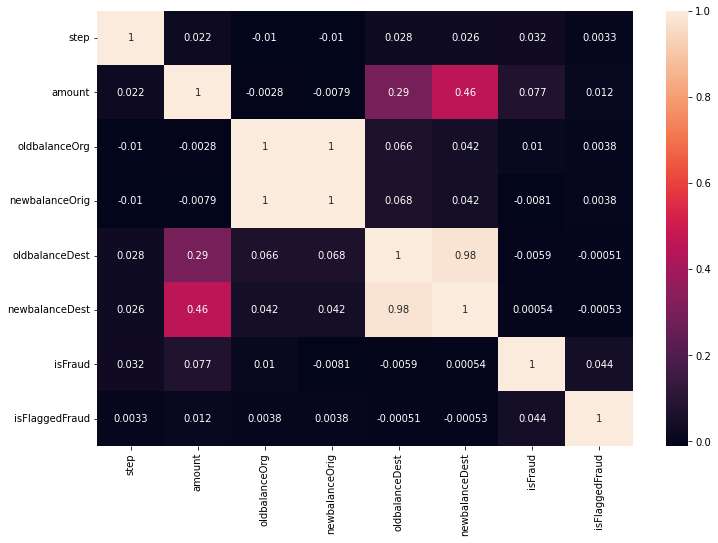

In [10]:
#heatmap of correlation
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)

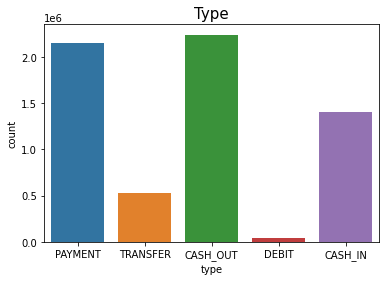

In [11]:
sns.countplot(x=df.type).set_title('Type',size=15);

In [12]:
#Select only row that have fraudulent transactions
df_fraud = df.loc[df['isFraud'] == 1] 


In [13]:
#In df that contains only fraudulent transaction, have only two categories "Cash_out" and "Transfer"
df_fraud['type'].value_counts(normalize = True)

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

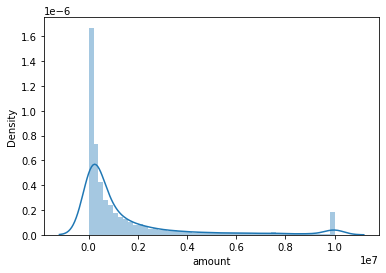

In [14]:
sns.distplot(df_fraud['amount'])

## Data pre-processing

In [15]:
#LabelEncoder 
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])
df['nameOrig'] = label_encoder.fit_transform(df['nameOrig'])
df['nameDest'] = label_encoder.fit_transform(df['nameDest'])

In [16]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.00,160296.36,1662094,0.00,0.00,0,0
1,1,3,1864.28,2188998,21249.00,19384.72,1733924,0.00,0.00,0,0
2,1,4,181.00,1002156,181.00,0.00,439685,0.00,0.00,1,0
3,1,1,181.00,5828262,181.00,0.00,391696,21182.00,0.00,1,0
4,1,3,11668.14,3445981,41554.00,29885.86,828919,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,5651847,339682.13,0.00,505863,0.00,339682.13,1,0
6362616,743,4,6311409.28,1737278,6311409.28,0.00,260949,0.00,0.00,1,0
6362617,743,1,6311409.28,533958,6311409.28,0.00,108224,68488.84,6379898.11,1,0
6362618,743,4,850002.52,2252932,850002.52,0.00,319713,0.00,0.00,1,0


## Balance the Data

In [17]:
#Split dataframe X and y.
X = df.loc[:, df.columns != 'isFraud']
y = df.loc[:, 'isFraud'] 

In [18]:
#Random Undersampling 
rus = RandomUnderSampler(random_state=Random_state, sampling_strategy=1)
X_resampled, y_resampled = rus.fit_resample(X, y)


## Train and Test the Model

In [19]:
def classification_whit_report(model, X, y, k, serial, verbose=False):
   
  fpr = []
  tpr = []
  roc_auc = []
  original_class = []
  predicted_class = []
  predicted_proba = []
  
  skf = StratifiedKFold(k)
  
  i = 0
  # Train and test the model for each `k` fold in all the data.
  for train_index, test_index in skf.split(X,y):
    if verbose:
      print(f'-- Running with {i}th fold.')
    model.fit(X.iloc[train_index], y[train_index])
    y_pred_probability = model.predict_proba(X.iloc[test_index])

    # Predict to generate classification report
    y_pred = model.predict(X.iloc[test_index])
    predicted_class.extend(y_pred)
    original_class.extend(y[test_index])
		
		# Compute micro-average ROC curve and ROC area.
    temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
    fpr.append(temp_fpr)
    tpr.append(temp_tpr)
    roc_auc.append(auc(temp_fpr,temp_tpr))
    i +=1

	#Plot the graphic
  plot_roc_curve(model, fpr, tpr, roc_auc, k)

  #Insert Results in file
  print ("== Confusion Matrix ==")
  print(confusion_matrix(original_class, predicted_class))
  print( "\n")
  print ("== Classification Report ==")
  print(classification_report(original_class, predicted_class))
  print( "\n")
  print ("== ROC AUC Values ==")
  print(roc_auc)



def plot_roc_curve(model, fpr, tpr, roc_auc, k):
  # Config the plot.
  plt.figure(figsize=(10, 10))
  plt.grid()
  plt.plot([0, 1], [0, 1], ls='--')
  plt.ylim([-0.01, 1.01])
  plt.xlim([-0.01, 1.01])
  plt.xlabel('False Positive Rate', size=16)
  plt.ylabel('True Positives Rate', size=16)

  linspace = np.linspace(0, 1, 100)

  # Calc the mean roc.
  int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
  mean_tpr = np.mean(int_tpr, axis=0)

  # Plot all roc curves for each fold and the average roc curve.
  for i in range(k):
    plt.plot(fpr[i], tpr[i], label=f'fold {i}, Area: {roc_auc[i]:.4f}')
  plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.4f} (+/- {np.std(roc_auc)*2:.2f})')

  # Plot the graphic.
  plt.legend(prop={'size': 16})
  plt.show()



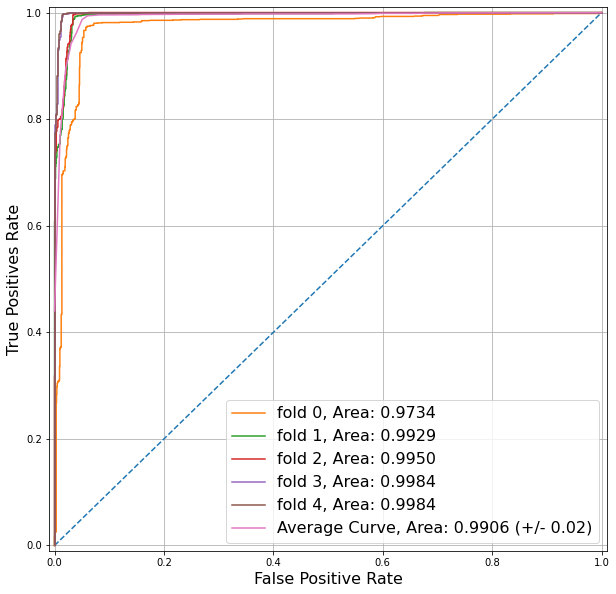

== Confusion Matrix ==
[[8072  141]
 [1518 6695]]


== Classification Report ==
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      8213
           1       0.98      0.82      0.89      8213

    accuracy                           0.90     16426
   macro avg       0.91      0.90      0.90     16426
weighted avg       0.91      0.90      0.90     16426



== ROC AUC Values ==
[0.9733877172711913, 0.9929172075382736, 0.9950027911569624, 0.9983616316369672, 0.9984161203585432]


In [20]:
#XGoost Classifier default
model = XGBClassifier() 
classification_whit_report(model, X_resampled, y_resampled, 5, '01', verbose=False)

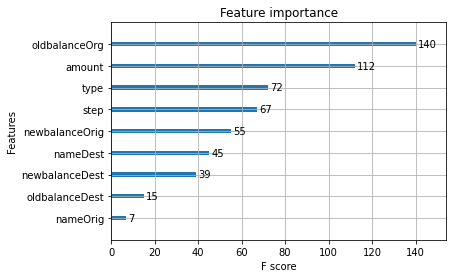

In [21]:
#Plot feature importance
plot_importance(model)
pyplot.show()